In [1]:
import torch
from torch import nn
import torchvision
import os
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
from tqdm.notebook import tqdm

In [2]:

dataroot = "C:/Users/MSI/torch-for-ml/Landscape Generation/Dataset"

workers = 2

batch_size = 128

image_size = 64

nc = 3

nz = 100


ngf = 64

ndf = 64

num_epochs = 20

lr = 0.0002

beta1 = 0.5

sample_dir="Generated"

In [3]:

dataset = torchvision.datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

### Visualizing Images

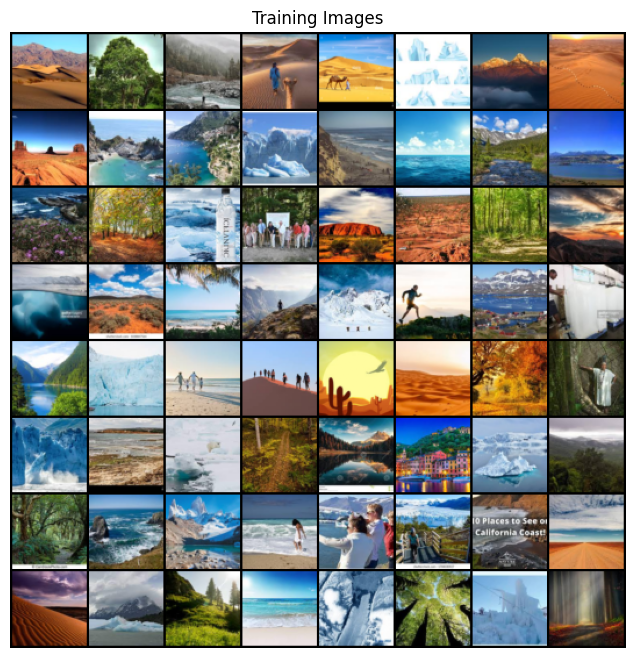

In [4]:

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### Creating Generator Model

In [5]:
generator=nn.Sequential(
            
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
)

### Defining Some Functions

In [6]:
def denorm(img_tensors):
  return img_tensors*beta1+beta1

In [7]:
def save_images(index,latent_tensors,show=True):
  fake_images=generator(latent_tensors)
  fake_fname='generated-images-{0:0=4d}.png'.format(index)
  torchvision.utils.save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=8)
  if show:
    fig,ax=plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

### Creating Discriminator

In [8]:
discriminator=nn.Sequential(
            
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
)

In [9]:
print(discriminator)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Sigmoid()
)


### Loss functions and Optimizers

In [26]:

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1,)


real_label = 1.
fake_label = 0.


optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

### Training Our Model

In [35]:

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in tqdm(enumerate(dataloader, 0)):
        discriminator.zero_grad()
        
        real_cpu = data[0]
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float,)
        
        output = discriminator(real_cpu).view(-1)
        
        errD_real = criterion(output, label)
        
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1,)
        
        fake = generator(noise)
        label.fill_(fake_label)
        
        output = discriminator(fake.detach()).view(-1)
        
        errD_fake = criterion(output, label)
        
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        
        optimizerD.step()

        
        generator.zero_grad()
        label.fill_(real_label)
        
        output = discriminator(fake).view(-1)
        
        errG = criterion(output, label)
        
        errG.backward()
        D_G_z2 = output.mean().item()
        
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
                save_images(epoch,fake)
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


0it [00:00, ?it/s]

[0/20][0/79]	Loss_D: 0.0375	Loss_G: 4.8757	D(x): 0.9914	D(G(z)): 0.0267 / 0.0257
[0/20][50/79]	Loss_D: 0.2076	Loss_G: 5.6589	D(x): 0.8396	D(G(z)): 0.0078 / 0.0060


0it [00:00, ?it/s]

[1/20][0/79]	Loss_D: 1.0976	Loss_G: 11.0651	D(x): 0.9977	D(G(z)): 0.5472 / 0.0001
[1/20][50/79]	Loss_D: 0.1498	Loss_G: 4.9780	D(x): 0.9740	D(G(z)): 0.1074 / 0.0124


0it [00:00, ?it/s]

[2/20][0/79]	Loss_D: 0.1537	Loss_G: 5.2451	D(x): 0.8929	D(G(z)): 0.0244 / 0.0085
[2/20][50/79]	Loss_D: 0.2203	Loss_G: 5.5013	D(x): 0.9850	D(G(z)): 0.1707 / 0.0059


0it [00:00, ?it/s]

[3/20][0/79]	Loss_D: 0.0701	Loss_G: 3.8367	D(x): 0.9721	D(G(z)): 0.0374 / 0.0469
[3/20][50/79]	Loss_D: 0.1760	Loss_G: 4.0009	D(x): 0.8951	D(G(z)): 0.0497 / 0.0284


0it [00:00, ?it/s]

[4/20][0/79]	Loss_D: 0.2700	Loss_G: 6.4555	D(x): 0.9629	D(G(z)): 0.1675 / 0.0047


KeyboardInterrupt: 

**After Training 25 Epochs You can get Images Like This You will get Good Results**